In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split

### importowanie danych z pliku
* tytuly obrazkow z kotami zaczynaja sie od wielkiej litery
* konwertujemy zdjecia na czarnobiale by nie marnowac pamieci komputera (kolory maja znikomy wplyw na skutecznosc naszej seici neuronowej)
* DATA  - lista z obrazkami 
* LABELS - lista z zerami i jedynkami 0 - pies 1 - kot
* N - ilosc zdjec


In [2]:
DATADIR = os.path.curdir + '/images/images'
N = 7394
DATA = np.zeros(N, dtype=object)
LABELS = np.zeros(N)  # 1 if cat 0 if dog
class_names = ['pies', 'kot']
with os.scandir(DATADIR) as images: 
    for i, img in enumerate(images):
        if cv2.haveImageReader(os.path.join(DATADIR, img.name)) and '.jpg' in img.name:
            LABELS[i] = (int(img.name[0].isupper()))
            DATA[i] = (cv2.imread(os.path.join(
                DATADIR, img.name), cv2.IMREAD_GRAYSCALE))

* normalizacja
* normalizowanie rozmiarów zdjec


In [3]:
IMG_SIZE = 128
data = np.zeros((N,IMG_SIZE,IMG_SIZE), dtype=np.float32)
for i in range(N):
     data[i] = cv2.resize(DATA[i], (IMG_SIZE, IMG_SIZE))

### wyswietlanie zdjec by "oswoic sie z danymi"

In [4]:
def show(data, labels):
    plt.figure(figsize=(15,10))
    for i in range(6):
        ax  = plt.subplot(2,3, i+1)
        index = np.random.choice(len(data))
        plt.imshow(data[index], cmap=plt.cm.binary)
        plt.title(labels[index])
        plt.axis(False)

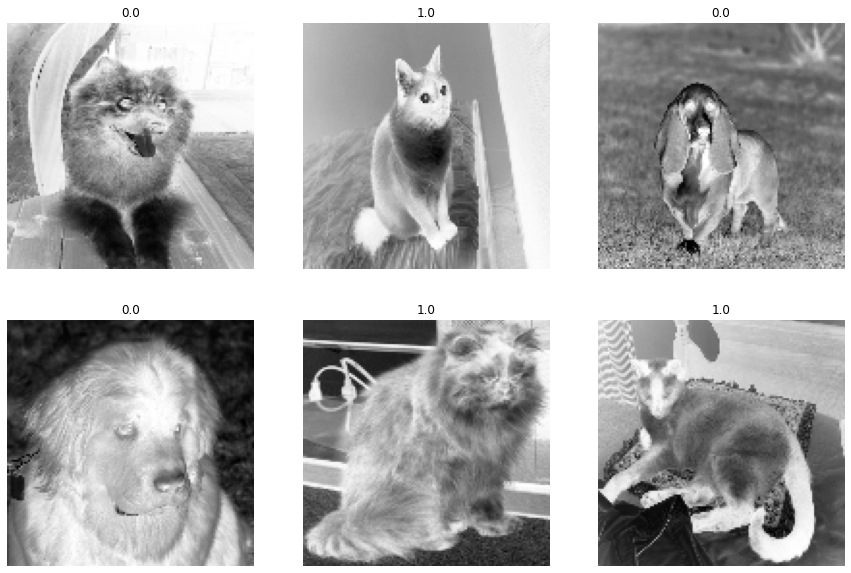

In [5]:
show(data, LABELS)

In [6]:
data = np.array(data).reshape(-1,IMG_SIZE,IMG_SIZE,1)/255.

### dzielenie danych na testowe i treningowe

In [7]:
train_d, test_d, train_l, test_l = train_test_split(data, LABELS, test_size=.3)
train_data = tf.convert_to_tensor(train_d, dtype=tf.float16)
test_data = tf.convert_to_tensor(test_d, dtype=tf.float16)
train_labels = tf.convert_to_tensor(train_l, dtype=tf.float16)
test_labels = tf.convert_to_tensor(test_l, dtype=tf.float16)

In [8]:
### zwwiekszamy wydajnosc biblioteki

#### tworzenie sieci neuronowej z uzyciem tensorflow

Epoch 1/10
81/81 [==============================] - 46s 555ms/step - loss: 1.2933 - accuracy: 0.6721 - val_loss: 0.5848 - val_accuracy: 0.6782
Epoch 2/10
81/81 [==============================] - 47s 582ms/step - loss: 0.4605 - accuracy: 0.7745 - val_loss: 0.6198 - val_accuracy: 0.7089
Epoch 3/10
81/81 [==============================] - 39s 486ms/step - loss: 0.3167 - accuracy: 0.8680 - val_loss: 0.6096 - val_accuracy: 0.7201
Epoch 4/10
81/81 [==============================] - 40s 499ms/step - loss: 0.2060 - accuracy: 0.9254 - val_loss: 0.7337 - val_accuracy: 0.7183
Epoch 5/10
81/81 [==============================] - 42s 523ms/step - loss: 0.1252 - accuracy: 0.9637 - val_loss: 0.8359 - val_accuracy: 0.7174
Epoch 6/10
81/81 [==============================] - 40s 496ms/step - loss: 0.0809 - accuracy: 0.9811 - val_loss: 0.9346 - val_accuracy: 0.6994
Epoch 7/10
81/81 [==============================] - 41s 501ms/step - loss: 0.0432 - accuracy: 0.9938 - val_loss: 1.1990 - val_accuracy: 0.7116

<AxesSubplot:>

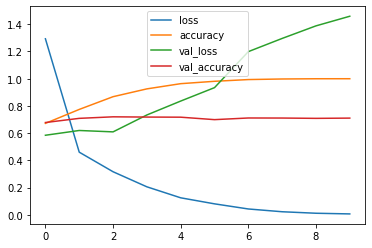

In [9]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (5,5), input_shape = train_data.shape[1:]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('sigmoid'))
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics= ['accuracy']
)
history = model.fit(train_data, train_labels, batch_size = 64, epochs=10,
                    verbose=1, validation_data=(test_data, test_labels))
pd.DataFrame(history.history).plot()

In [10]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [11]:
pred_t = model.predict(test_data)

In [12]:
pred = np.round(pred_t).reshape(-1)

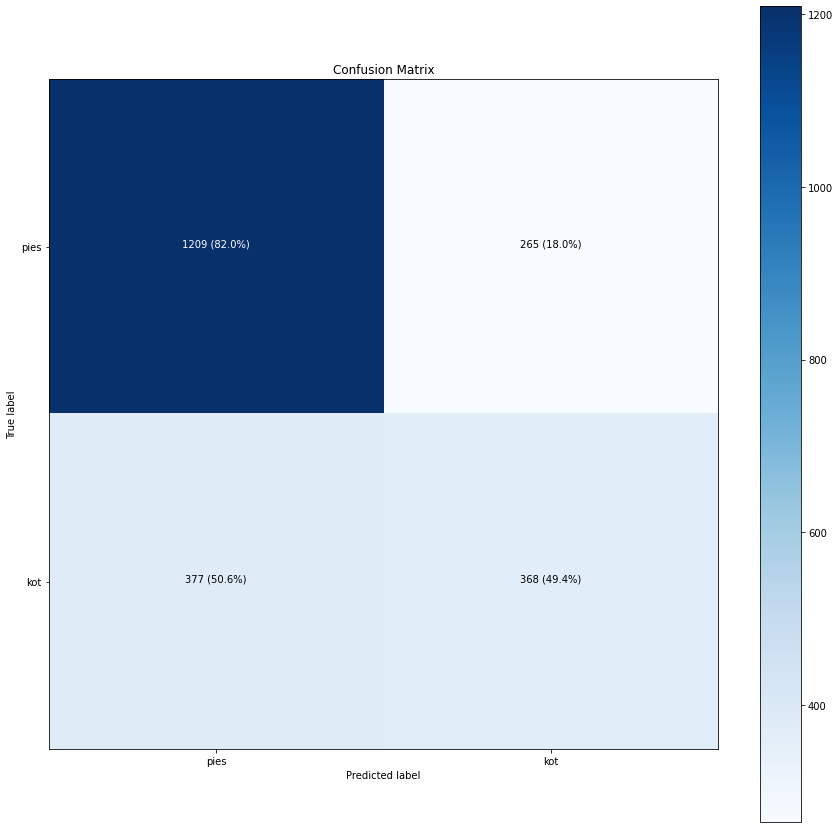

In [13]:

# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=test_labels, 
                 y_pred = pred)


make_confusion_matrix(y_true=test_labels, 
                      y_pred= np.array(np.round(pred), np.bool8),
                      classes=['pies','kot'],
                      figsize=(15, 15),
                      text_size=10)

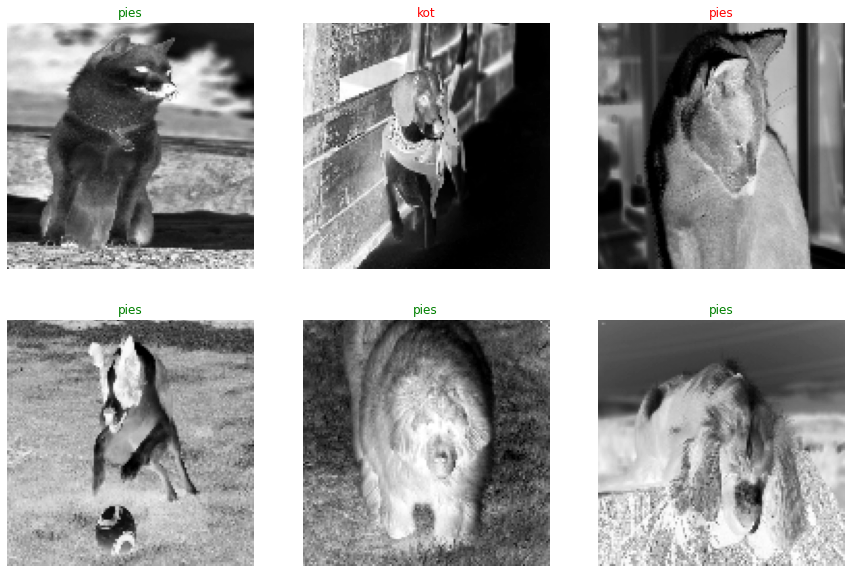

In [14]:

plt.figure(figsize=(15,10))
for i in range(6):
    ax  = plt.subplot(2,3, i+1)
    index = np.random.choice(len(test_data))
    pred_y = class_names[int(pred[index])]
    plt.imshow(test_d[index], cmap=plt.cm.binary)
    if pred_y == class_names[int(test_l[index])]:
        color = "green"
    else:
        color = "red"
    plt.title((pred_y),color=color)
    plt.axis(False)